In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [155]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(train.shape, test.shape)

(38932, 5) (29404, 4)


In [156]:
train

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy
...,...,...,...,...,...
38927,id49253,We arrived late at night and walked in to a ch...,Edge,Desktop,happy
38928,id49254,The only positive impression is location and p...,InternetExplorer,Mobile,not happy
38929,id49255,Traveling with friends for shopping and a show...,Firefox,Mobile,not happy
38930,id49256,The experience was just ok. We paid extra for ...,Chrome,Desktop,not happy


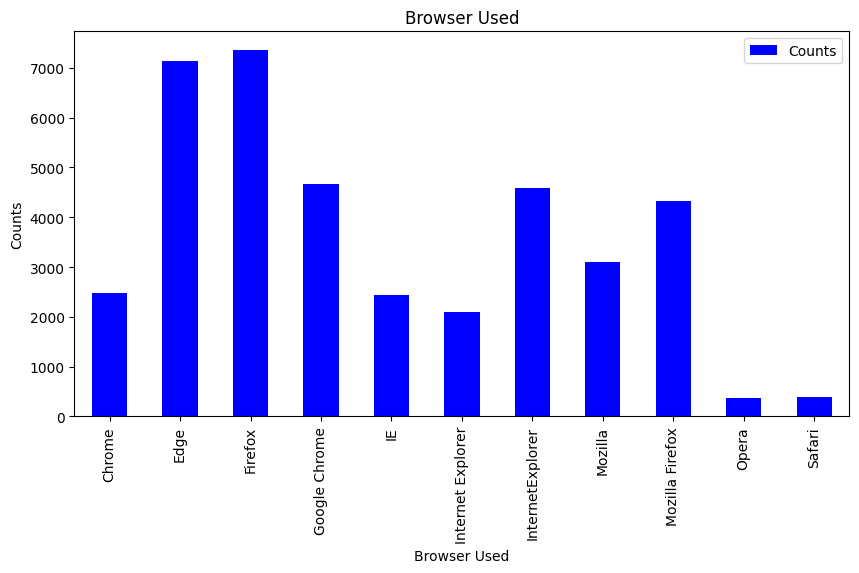

In [157]:
# Groupby browser used, drop all column since all values will be the same, keep one, and rename it counts.
browser_counts = train.groupby('Browser_Used').count().drop(['User_ID', 'Description', 'Is_Response'], axis=1).rename(columns={'Device_Used': 'Counts'})

# BarChart of browser used with sns
browser_counts.plot(kind='bar', figsize=(10, 5), color='blue')
plt.title('Browser Used')
plt.xlabel('Browser Used')
plt.ylabel('Counts')
plt.show()


In [158]:
# From the graph we can see that the same browser have been used, but it was imputed with a different name. Let's combine the browsers that are the same.
train['Browser_Used'] = train['Browser_Used'].replace('Chrome', 'Google Chrome')
train['Browser_Used'] = train['Browser_Used'].replace('Mozilla', 'Firefox')
train['Browser_Used'] = train['Browser_Used'].replace('Mozilla Firefox', 'Firefox')
train['Browser_Used'] = train['Browser_Used'].replace('IE', 'Internet Explorer')
train['Browser_Used'] = train['Browser_Used'].replace('InternetExplorer', 'Internet Explorer')

# Doing the same for the test set
test['Browser_Used'] = test['Browser_Used'].replace('Chrome', 'Google Chrome')
test['Browser_Used'] = test['Browser_Used'].replace('Mozilla', 'Firefox')
test['Browser_Used'] = test['Browser_Used'].replace('Mozilla Firefox', 'Firefox')
test['Browser_Used'] = test['Browser_Used'].replace('IE', 'Internet Explorer')
test['Browser_Used'] = test['Browser_Used'].replace('InternetExplorer', 'Internet Explorer')

In [159]:
train['Browser_Used'].value_counts()

Browser_Used
Firefox              14787
Internet Explorer     9130
Edge                  7134
Google Chrome         7129
Safari                 390
Opera                  362
Name: count, dtype: int64

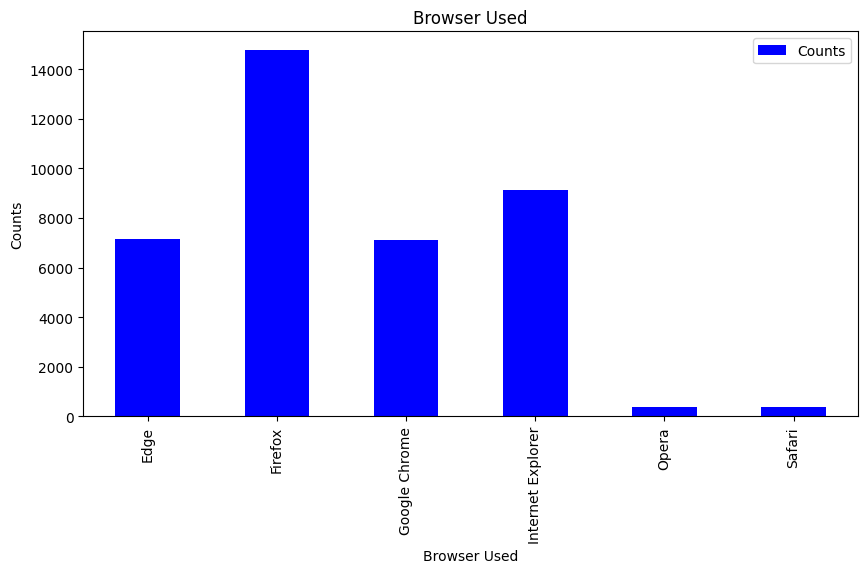

In [160]:
# Groupby browser used, drop all column since all values will be the same, keep one, and rename it counts.
browser_counts = train.groupby('Browser_Used').count().drop(['User_ID', 'Description', 'Is_Response'], axis=1).rename(columns={'Device_Used': 'Counts'})

# BarChart of browser used with sns
browser_counts.plot(kind='bar', figsize=(10, 5), color='blue')
plt.title('Browser Used')
plt.xlabel('Browser Used')
plt.ylabel('Counts')
plt.show()


We have cleaned the repeated Browsers!!!

Now let's look at the `distribution of responses` between the people that stated that they were happy or not.

**I plan to:**
1. Do some EDA on the data
2. Run some TFIDF to check for the responses themselves, and try to classify if the response was in fact negative or positive.

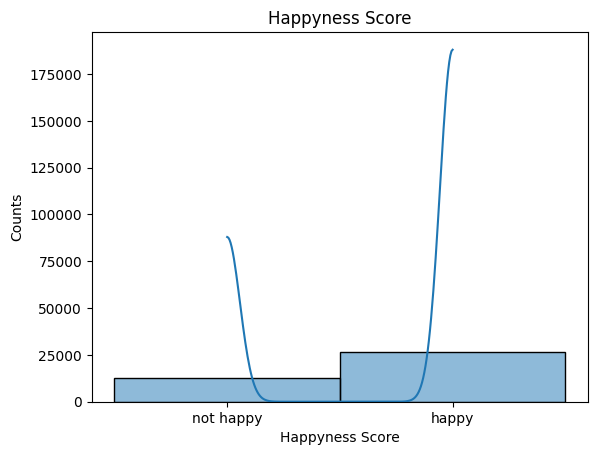

In [161]:
# SNS Graph of happyness score
sns.histplot(train['Is_Response'], bins=10, kde=True)
plt.title('Happyness Score')
plt.xlabel('Happyness Score')
plt.ylabel('Counts')
plt.show()


In [162]:
# Running TF-IDF on the description column
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

# Split the data into training and testing sets
train_data, test_data = train_test_split(train, test_size=0.2)

# Create a pipeline that first transforms the text into TF-IDF features and then applies a classifier
train_pipeline = Pipeline([

    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression())
])

# Train the pipeline on the training data
train_pipeline.fit(train_data['Description'], train_data['Is_Response'])

# Predict the labels for the test data
predictions = train_pipeline.predict(test_data['Description'])

# Print the accuracy of the model
print('Accuracy:', accuracy_score(test_data['Is_Response'], predictions))

# Print the confusion matrix
print('Confusion Matrix:\n', confusion_matrix(test_data['Is_Response'], predictions))


Accuracy: 0.8839090792346218
Confusion Matrix:
 [[5017  302]
 [ 602 1866]]


In [163]:
# Create the vectorizer and classifier separately for easier access
tfidf = TfidfVectorizer(stop_words='english')
clf = LogisticRegression()

In [164]:
# Fit TF-IDF on training data and transform both train and test
X_train_tfidf = tfidf.fit_transform(train_data['Description'])
X_test_tfidf = tfidf.transform(test_data['Description'])

In [165]:
clf.fit(X_train_tfidf, train_data['Is_Response'])

LogisticRegression()

In [166]:
# Predict sentiment labels
predictions = clf.predict(X_test_tfidf)
test_data = test_data.copy()  # Avoid changing the original test set

In [167]:
# Assign predictions
test_data['Predicted_Label'] = predictions

# Map string labels to sentiment names
label_map = {
    'happy': 'Positive',
    'not happy': 'Negative'
}

test_data['Sentiment'] = test_data['Predicted_Label'].map(label_map)


In [168]:
# Get feature names and coefficients
feature_names = np.array(tfidf.get_feature_names_out())
coefs = clf.coef_[0]

In [169]:
def get_important_words(text, top_n=3):
    """
    Return the most influential words in a sentence based on TF-IDF * model weight.
    """
    tfidf_vector = tfidf.transform([text])
    word_indices = tfidf_vector.indices
    word_scores = tfidf_vector.data * coefs[word_indices]
    top_indices = np.argsort(word_scores)[-top_n:]
    return [feature_names[word_indices[i]] for i in top_indices[::-1]]

In [170]:
# Add column with top words
test_data['Top_Words'] = test_data['Description'].apply(lambda x: get_important_words(x, top_n=3))

In [172]:
test_data[['Description', 'Sentiment', 'Top_Words']].head(10)

,Description,Sentiment,Top_Words
38483,The hotel is in Times Square as the name state...,Positive,"[looks, day, funny]"
4206,We resisted advise to stay in the heart of Tim...,Positive,"[advise, location, blakely]"
30802,The price for my stay in December was approxim...,Negative,"[walls, room, night]"
35052,I stayed here for - nights on business and bel...,Negative,"[average, room, tired]"
10512,Even though their web site shows bell hops wai...,Negative,"[loud, waiting, luckily]"
18197,The Affinia Dumont is certainly all the review...,Positive,"[basic, bed, old]"
19754,Really enjoyed the night I stayed at the Hudso...,Positive,"[told, weird, small]"
29246,Stayed here on business because my colleague a...,Negative,"[told, average, ok]"
19144,The hotel is a great value for Union Square. I...,Positive,"[rude, room, hotel]"
19320,"Superb. From check in to check out, everything...",Positive,"[location, room, desk]"
